# Когортный анализ - среднее кол-во покупок

## Описание

В датасете game_purchases.csv записаны данные о покупках, совершённых внутри мобильной стратегической игры «Крэш оф Крэнс». В столбцах таблицы:   

`purchase_datetime` — дата и время покупки;   
`player_id` — уникальный идентификатор игрока;   
`item` — название купленной игровой единицы: life (англ. «жизнь»), mana (англ. «магическая сила», в играх — «топливо» для заклинаний), armour (англ. «броня»);   
`price` — цена во внутриигровой валюте;   
`purchase_id` — уникальный идентификатор покупки.

## Задача
Построить когорты и для каждой из них найти среднее количесво покупок.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [27]:
purchases = pd.read_csv('game_purchases.csv')
purchases.head(5) # выводим первые 5 строк

,purchase_datetime,player_id,item,price,purchase_id
0,2019-01-01 00:15:54,2434d4ef-7949-4311-a9e6-9263e2ea2b7c,armour,0.1,10423
1,2019-01-01 00:16:56,1ecd854d-f707-44a2-b174-0c0039668650,life,0.3,10424
2,2019-01-01 00:56:17,1156b1a0-732b-4732-ab41-79f77cd0e719,life,0.3,10425
3,2019-01-01 00:58:17,1f7b30f3-26ac-45bd-82b4-30fad1d1398d,armour,0.1,10426
4,2019-01-01 01:15:42,4697efd3-15b2-4f40-84fb-7e5c65e390c9,armour,0.1,10427


In [31]:
print('Размер таблицы:',purchases.shape)

Размер таблицы: (16666, 5)


In [22]:
# Формируем когорты по месяцам покупки
first_purchase_dates = purchases.groupby('player_id')['purchase_datetime'].min()
first_purchase_dates.name =  'first_purchase_datetime'

purchases = purchases.join(first_purchase_dates, on = 'player_id')

purchases['purchase_month'] = purchases['purchase_datetime'].astype('datetime64[M]')
purchases['first_purchase_month'] = purchases['first_purchase_datetime'].astype('datetime64[M]')

cohort_stats = purchases.groupby('first_purchase_month')['price'].sum()

print(cohort_stats)

first_purchase_month
2019-01-01    2432.2
2019-02-01     602.5
2019-03-01     292.7
2019-04-01     192.8
2019-05-01     108.5
2019-06-01      72.8
2019-07-01      46.7
Name: price, dtype: float64


**Вывод:** С течением времени пользователи тратят всё меньше игровой валюты. Это требует дополнительного анализа.

Сформируем сводную таблицу, в которой отразим изменение среднего количества покупок на игрока по когортам в различных месяцах.

In [17]:
# найдём первую дату покупки
purchases = pd.read_csv('game_purchases.csv')
first_purchase_dates = purchases.groupby('player_id')[
    'purchase_datetime'
].min()

# укажем размерность временной метки и приведём данные к нужному формату
first_purchase_dates.name = 'first_purchase_datetime'
purchases = purchases.join(first_purchase_dates, on='player_id')
purchases['purchase_month'] = purchases['purchase_datetime'].astype(
    'datetime64[M]'
)

purchases['first_purchase_month'] = purchases[
    'first_purchase_datetime'
].astype('datetime64[M]')

purchases_grouped_by_cohorts = purchases.groupby(['first_purchase_month', 'purchase_month'])['purchase_id','player_id'].nunique()
purchases_grouped_by_cohorts['purchases_per_player'] = purchases_grouped_by_cohorts['purchase_id'] / purchases_grouped_by_cohorts['player_id']
mean_purchases_pivot  = purchases_grouped_by_cohorts.pivot_table(index = 'first_purchase_month', columns='purchase_month', values = 'purchases_per_player', aggfunc='sum')
mean_purchases_pivot.head(10)

<ipython-input-17-89ea5403049a>:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  purchases_grouped_by_cohorts = purchases.groupby(['first_purchase_month', 'purchase_month'])['purchase_id','player_id'].nunique()


purchase_month,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01
first_purchase_month,,,,,,,
2019-01-01,1.671333,2.045802,2.067055,2.177979,2.137462,2.000000,2.025602
2019-02-01,NaN,1.256881,1.456522,1.359833,1.361538,1.362832,1.384921
2019-03-01,NaN,NaN,1.175601,1.246032,1.297710,1.330769,1.288136
2019-04-01,NaN,NaN,NaN,1.149425,1.310680,1.219780,1.320388
2019-05-01,NaN,NaN,NaN,NaN,1.085366,1.145455,1.166667
2019-06-01,NaN,NaN,NaN,NaN,NaN,1.116183,1.170732
2019-07-01,NaN,NaN,NaN,NaN,NaN,NaN,1.072917


**Вывод:** видно как именяется среднее количесво внутриигровых покупок в зависимости от месяца покупки и когорты. Например: пользователи майской когорты покупают гораздо хуже январской.

In [15]:
purchases_grouped_by_cohorts = purchases_grouped_by_cohorts.reset_index()
purchases_grouped_by_cohorts['cohort_lifetime'] = purchases_grouped_by_cohorts['purchase_month'] - purchases_grouped_by_cohorts['first_purchase_month']
purchases_grouped_by_cohorts['cohort_lifetime'] = (purchases_grouped_by_cohorts['cohort_lifetime']/np.timedelta64(1,'M')).round()
purchases_grouped_by_cohorts['cohort_lifetime'] = purchases_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

**Вывод:** Теперь в таблице для каждого месяца есть,  — порядковый номер месяца относительно старта когорты.

In [16]:
lifetime_pivot  = purchases_grouped_by_cohorts.pivot_table(index = 'first_purchase_month', columns = 'cohort_lifetime', values = 'purchases_per_player', aggfunc = 'mean')
lifetime_pivot

cohort_lifetime,0,1,2,3,4,5,6
first_purchase_month,,,,,,,
2019-01-01,1.671333,2.045802,2.067055,2.177979,2.137462,2.000000,2.025602
2019-02-01,1.256881,1.456522,1.359833,1.361538,1.362832,1.384921,NaN
2019-03-01,1.175601,1.246032,1.297710,1.330769,1.288136,NaN,NaN
2019-04-01,1.149425,1.310680,1.219780,1.320388,NaN,NaN,NaN
2019-05-01,1.085366,1.145455,1.166667,NaN,NaN,NaN,NaN
2019-06-01,1.116183,1.170732,NaN,NaN,NaN,NaN,NaN
2019-07-01,1.072917,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод:** построили таблицу с когортным анализом среднего числа покупок игрока с разбивкой по времени жизни. Во всех когортах на первый месяц по сравнению с нулевым среднее количество покупок возрастает. Это говорит, что игроки активнее всего покупают не сразу, а по истечении некоторого времени, например, когда разберутся с устройством игрового мира.   

Также есть когорты, в которых у игроков среднее количество покупок растёт с течением времени. Например, у апрельской когорты.    

## Тепловая карта

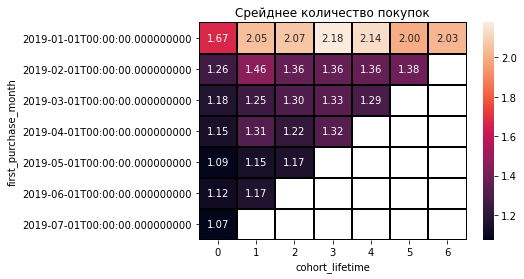

<Figure size 936x648 with 0 Axes>

In [13]:
sns.heatmap(lifetime_pivot, annot = True, fmt='.2f', linewidths=1, linecolor = 'black')
plt.title('Срейднее количество покупок')
plt.figure(figsize=(13, 9))
plt.show()

**Вывод:** Сильнее всех выделяется январь 2019 года. Средноличесво покупок в этой кагорте значительно вышем, чем в остальных. Возможно рождественские акции простимулировали клиентов.